# AutoEncoder

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False, cache=False)

In [2]:
from sklearn.model_selection import train_test_split
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=60000, random_state=42)
# X_train = X_train.reshape(-1,28,28)
# X_test = X_test.reshape(-1,28,28)
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


## 구축

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, latent_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, input_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
inputsize = 784
hiddensize1 = 256
hiddensize2 = 128
latentsize = 32
epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
autoencoder = AutoEncoder(inputsize, hiddensize1, hiddensize2, latentsize)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
loss = nn.MSELoss()


In [12]:
trainDS = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_train))
trainloader = DataLoader(trainDS, batch_size=128, shuffle=True)

In [15]:
autoencoder.to(device)
loss.to(device)
for epoch in range(epochs):
    loss_val = 0
    for x, _ in trainloader:
        x = x.to(device)
        x = x.view(-1, 784)
        x_hat = autoencoder(x)
        criterion = loss(x_hat, x)
        optimizer.zero_grad()
        criterion.backward()
        optimizer.step()
        loss_val += criterion.item()*x.size(0)
    loss_val /= len(trainloader.dataset)
    print(f'Epoch: {epoch+1}, Loss: {loss_val:.4f}')

Epoch: 1, Loss: 0.0516
Epoch: 2, Loss: 0.0252
Epoch: 3, Loss: 0.0195
Epoch: 4, Loss: 0.0168
Epoch: 5, Loss: 0.0147
Epoch: 6, Loss: 0.0133
Epoch: 7, Loss: 0.0122
Epoch: 8, Loss: 0.0114
Epoch: 9, Loss: 0.0108
Epoch: 10, Loss: 0.0103


In [16]:
X_test_hat = autoencoder(torch.from_numpy(X_test).to(device))
X_test_hat = X_test_hat.detach().cpu().numpy().reshape(-1,28,28)
X_test_hat.shape

(10000, 28, 28)

## 원본 이미지와 복원된 이미지 비교


Bad key "text.kerning_factor" on line 4 in
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


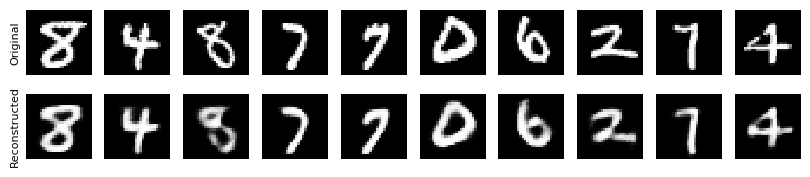

In [10]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2, 10, figsize=(10, 2))
ax_upper = ax[0,:]
ax_lower = ax[1,:]

for i in range(10):
    ax_upper[i].imshow(X_test[i].reshape(28,28), cmap='gray')
    ax_lower[i].imshow(X_test_hat[i], cmap='gray')
    ax_upper[i].set_xticks([])
    ax_upper[i].set_yticks([])
    ax_lower[i].set_xticks([])
    ax_lower[i].set_yticks([])
    for pos in ['right', 'top', 'bottom', 'left']:
        ax_upper[i].spines[pos].set_visible(False)
        ax_lower[i].spines[pos].set_visible(False)
    if i==0:
        ax_upper[i].set_ylabel('Original',fontsize=8)
        ax_lower[i].set_ylabel('Reconstructed',fontsize=8)
plt.show()

## 저차원 벡터 (representation vector)를 이용한 분류

In [12]:
X_train_encode = autoencoder.encoder(torch.from_numpy(X_train).to(device))
X_train_encode = X_train_encode.detach().cpu().numpy()
print(X_train_encode.shape)
X_test_encode = autoencoder.encoder(torch.from_numpy(X_test).to(device))
X_test_encode = X_test_encode.detach().cpu().numpy()
print(X_test_encode.shape)

(60000, 32)
(10000, 32)


In [13]:
from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit

simple_clf = nn.Sequential(nn.Linear(32,128),
                           nn.ReLU(),
                           nn.Linear(128,10)
                            )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



net = NeuralNetClassifier(simple_clf, 
                        max_epochs=20, 
                        lr=0.001, 
                        device=device,
                        criterion=nn.CrossEntropyLoss, 
                        optimizer=torch.optim.RMSprop,
                        train_split=ValidSplit(5),
                        batch_size=128
                        )

In [14]:
net.fit(X_train_encode, y_train)
print('train completed')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5733       0.8883        0.3690  0.6374
      2        0.3327       0.9120        0.2980  0.6258
      3        0.2737       0.9272        0.2519  0.6942
      4        0.2319       0.9375        0.2197  0.6008
      5        0.2026       0.9427        0.1970  0.6856
      6        0.1822       0.9483        0.1801  0.6063
      7        0.1673       0.9522        0.1667  0.6090
      8        0.1560       0.9548        0.1575  0.6008
      9        0.1472       0.9573        0.1499  0.6137
     10        0.1401       0.9597        0.1437  0.6122
     11        0.1342       0.9610        0.1376  0.6380
     12        0.1291       0.9613        0.1334  0.6287
     13        0.1245       0.9620        0.1294  0.6941
     14        0.1205       0.9632        0.1275  0.6055
     15        0.1169       0.9638        0.1256  0.6407
     16        0.1136       0.9

In [15]:
from sklearn.metrics import accuracy_score
y_test_pred = net.predict(X_test_encode)
accuracy_score(y_test, y_test_pred)

0.9615

# Convolutional Autoencoder
## 구축

In [3]:
class cnnAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
cnnAE = cnnAutoEncoder()
cnnAE(torch.from_numpy(X_train[0:4]).float().view(-1,1,28,28)).shape

torch.Size([4, 1, 28, 28])

In [5]:
X_train_2d = X_train.reshape(-1,1,28,28)
X_test_2d = X_test.reshape(-1,1,28,28)

In [6]:
epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(cnnAE.parameters(), lr=0.001)
loss = nn.MSELoss()

trainDS = TensorDataset(torch.from_numpy(X_train_2d), torch.from_numpy(X_train_2d))
trainloader = DataLoader(trainDS, batch_size=128, shuffle=True)
testDS = TensorDataset(torch.from_numpy(X_test_2d), torch.from_numpy(X_test_2d))
testloader = DataLoader(testDS, batch_size=128, shuffle=True)

In [7]:
cnnAE.to(device)
for epoch in range(epochs):
    cnnAE.train()
    train_loss = 0
    for x, _ in trainloader:
        x = x.to(device)
        x = x.view(-1,1,28,28)
        x_hat = cnnAE(x)
        criterion = loss(x_hat, x)
        optimizer.zero_grad()
        criterion.backward()
        optimizer.step()
        train_loss += criterion.item()*x.size(0)
    train_loss /= len(trainloader.dataset)
    
    with torch.no_grad():
        cnnAE.eval()
        val_loss = 0
        for x, _ in testloader:
            x = x.to(device)
            x = x.view(-1,1,28,28)
            x_hat = cnnAE(x)
            criterion = loss(x_hat, x)
            val_loss += criterion.item()*x.size(0)
        val_loss /= len(testloader.dataset)
    print(f'Epoch: {epoch+1}, train Loss: {train_loss:.4f}, val loss: {val_loss:.4f}')


Epoch: 1, train Loss: 0.0127, val loss: 0.0041
Epoch: 2, train Loss: 0.0035, val loss: 0.0030
Epoch: 3, train Loss: 0.0027, val loss: 0.0025
Epoch: 4, train Loss: 0.0024, val loss: 0.0022
Epoch: 5, train Loss: 0.0021, val loss: 0.0020
Epoch: 6, train Loss: 0.0020, val loss: 0.0019
Epoch: 7, train Loss: 0.0018, val loss: 0.0018
Epoch: 8, train Loss: 0.0017, val loss: 0.0016
Epoch: 9, train Loss: 0.0016, val loss: 0.0016
Epoch: 10, train Loss: 0.0015, val loss: 0.0015


In [9]:
cnnAE.cpu()
X_test_2d_hat = cnnAE(torch.from_numpy(X_test_2d))
X_test_2d_hat = X_test_2d_hat.detach().numpy()
X_test_2d_hat.shape

(10000, 1, 28, 28)

## 원본 이미지와 복원된 이미지 비교

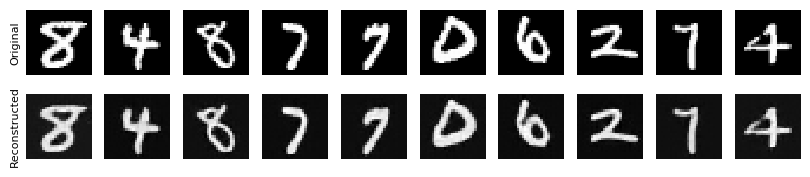

In [36]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2, 10, figsize=(10, 2))
ax_upper = ax[0,:]
ax_lower = ax[1,:]

for i in range(10):
    ax_upper[i].imshow(X_test_2d[i].squeeze(), cmap='gray')
    ax_lower[i].imshow(X_test_2d_hat[i].squeeze(), cmap='gray')
    ax_upper[i].set_xticks([])
    ax_upper[i].set_yticks([])
    ax_lower[i].set_xticks([])
    ax_lower[i].set_yticks([])
    for pos in ['right', 'top', 'bottom', 'left']:
        ax_upper[i].spines[pos].set_visible(False)
        ax_lower[i].spines[pos].set_visible(False)
    if i==0:
        ax_upper[i].set_ylabel('Original',fontsize=8)
        ax_lower[i].set_ylabel('Reconstructed',fontsize=8)
plt.show()

## 저차원 벡터 (representation vector)를 이용한 분류

In [45]:
# cuda memory error로 x_train_2d_encode를 따로 모아두지는 않음

simple_clf = nn.Sequential(nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
                            nn.Flatten(),
                            nn.ReLU(),
                            nn.Linear(7*7,128),
                            nn.ReLU(),
                            nn.Linear(128,10)
                            )
optimizer = torch.optim.RMSprop(simple_clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20

In [17]:
from sklearn.model_selection import train_test_split
X_train_2d, X_val_2d, y_train, y_val = train_test_split(X_train_2d, y_train, test_size=0.2, random_state=42)

In [19]:
trainDS = TensorDataset(torch.from_numpy(X_train_2d), torch.from_numpy(y_train))
valDS = TensorDataset(torch.from_numpy(X_val_2d), torch.from_numpy(y_val))
trainloader = DataLoader(trainDS, batch_size=128, shuffle=True)
valloader = DataLoader(valDS, batch_size=128, shuffle=False)

In [46]:
cnnAE.to(device)
simple_clf.to(device)
for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    simple_clf.train()
    for i,(inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs_encode = cnnAE.encoder(inputs)

        optimizer.zero_grad()
        outputs = simple_clf(inputs_encode)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == targets.data)
    train_loss /= len(trainloader.dataset)
    train_acc = train_correct.double() / len(trainloader.dataset)
    print(f'Epoch: {epoch+1}, train Loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

    val_loss = 0
    val_correct = 0
    simple_clf.eval()
    with torch.no_grad():
        for i,(inputs, targets) in enumerate(valloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            inputs_encode = cnnAE.encoder(inputs)

            outputs = simple_clf(inputs_encode)
            loss = criterion(outputs, targets)
            val_loss += loss.item()*inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == targets.data)
    val_loss /= len(valloader.dataset)
    val_acc = val_correct.double() / len(valloader.dataset)
    print(f'val Loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

Epoch: 1, train Loss: 0.4590, train acc: 0.8532
val Loss: 0.2506, val acc: 0.9230
Epoch: 2, train Loss: 0.2185, train acc: 0.9317
val Loss: 0.1810, val acc: 0.9432
Epoch: 3, train Loss: 0.1637, train acc: 0.9476
val Loss: 0.1413, val acc: 0.9563
Epoch: 4, train Loss: 0.1363, train acc: 0.9574
val Loss: 0.1321, val acc: 0.9587
Epoch: 5, train Loss: 0.1194, train acc: 0.9625
val Loss: 0.1172, val acc: 0.9628
Epoch: 6, train Loss: 0.1061, train acc: 0.9667
val Loss: 0.1104, val acc: 0.9632
Epoch: 7, train Loss: 0.0979, train acc: 0.9691
val Loss: 0.1082, val acc: 0.9647
Epoch: 8, train Loss: 0.0890, train acc: 0.9716
val Loss: 0.1013, val acc: 0.9672
Epoch: 9, train Loss: 0.0833, train acc: 0.9739
val Loss: 0.1020, val acc: 0.9676
Epoch: 10, train Loss: 0.0780, train acc: 0.9754
val Loss: 0.0903, val acc: 0.9715
Epoch: 11, train Loss: 0.0727, train acc: 0.9764
val Loss: 0.0847, val acc: 0.9731
Epoch: 12, train Loss: 0.0686, train acc: 0.9781
val Loss: 0.0868, val acc: 0.9712
Epoch: 13, tr

In [47]:
X_test_2d_encode = cnnAE.encoder(torch.from_numpy(X_test_2d).to(device))
X_test_2d_encode = X_test_2d_encode.detach().cpu().numpy()
print(X_test_2d_encode.shape)

(10000, 32, 7, 7)


In [48]:
from sklearn.metrics import accuracy_score
y_test_hat = simple_clf(torch.from_numpy(X_test_2d_encode).to(device))
accuracy_score(y_test, y_test_hat.argmax(dim=1).detach().cpu().numpy())

0.9736